In [21]:
import numpy
import astropy.units as u
import mcmillan
import os
import pickle
import orbit_helper
from galpy import potential
from galpy import actionAngle
from galpy.util import bovy_conversion, bovy_plot
R0, V0= 8.21*u.kpc, 233.1*u.km/u.s


params = {'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'text.usetex': True, 'lines.linewidth' : 1, 'axes.titlesize' : 15, 'font.family' : 'serif'}
plt.rcParams.update(params)
columnwidth = 240./72.27
textwidth = 504.0/72.27
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
mcm17= mcmillan.McMillan2017

# Some tests of the McMillan (2017) potential implemented in ``galpy`` functions

This notebook tests the implementation of the McMillan (2017) potential for estimating orbit parameters via the stackel approximation, as in Mackereth and Bovy (2018). We first check that the implementation is robust, then replicate the tests of the method using this potential. The results of the grid computation were used in the paper, but the plots were not included - but are informative in understanding how the choice of potential might affect results of estimating orbit parameters.

## Checks against the McMillan (2017) paper

Let's check some of the numbers in Table 3 of McMillan (2017):

In [3]:
print("Kz force at the solar circle: {:.2f}"\
      .format(-potential.evaluatezforces(mcm17,8.21*u.kpc,1.1*u.kpc,use_physical=False)
              *bovy_conversion.force_in_2piGmsolpc2(V0.to(u.km/u.s).value,R0.to(u.kpc).value)))

Kz force at the solar circle: 74.09


In [4]:
print("Halo density at the solar circle: {:.4f}"\
      .format(potential.evaluateDensities(mcm17[1],8.21*u.kpc,0.,use_physical=False)
              *bovy_conversion.dens_in_msolpc3(V0.to(u.km/u.s).value,R0.to(u.kpc).value)))

Halo density at the solar circle: 0.0101


In [5]:
print("Halo concentration: {:.1f}".format(mcm17[1].conc(overdens=94.,wrtcrit=True,H=70.4)))

Halo concentration: 15.4


With the current implementation of DiskSCFPotential, we cannot compute the mass of the disk and bulge components, but let's compute that of the NFWPotenial and add the paper's number for the mass in stars and gas. The following is the total mass in units of $10^11\,M_\odot$:

In [6]:
(mcm17[1].mass(50.*u.kpc))/10.**11.+0.543+0.122

5.0999121875442341

That seems reasonable given figure 6.

The rotation curve is:

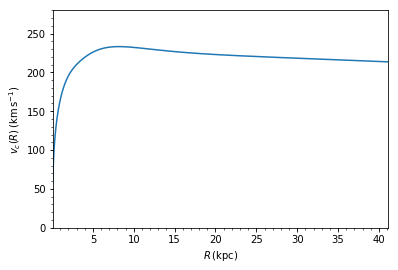

In [7]:
potential.plotRotcurve(mcm17)

which seems plausible (the rotation curve does not seem to be given by McMillan 2017).

## Some tests of the implementation

All of the potential is approximated using the ``DiskSCFPotential`` approximation, so let's test to see whether the densities that come out of the DiskSCFPotential agree with those that went in!

The following is the test of the density along lines $z = X R$ from the ``galpy`` docs (see [here](http://galpy.readthedocs.io/en/latest/potential.html#new-in-v1-2-updated-in-v1-3-general-density-potential-pairs-with-basis-function-expansions)), using the density of all but the halo. The total density (including the halo) is included as the red line, to give a sense of whether we match the density well in all regions where it matters.

/home/astjmack/anaconda2/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/potential_src/DiskSCFPotential.py:256: RuntimeWarning: overflow encountered in square
  th= lambda z, tzd=zd: 1./numpy.cosh(z/2./tzd)**2./4./tzd



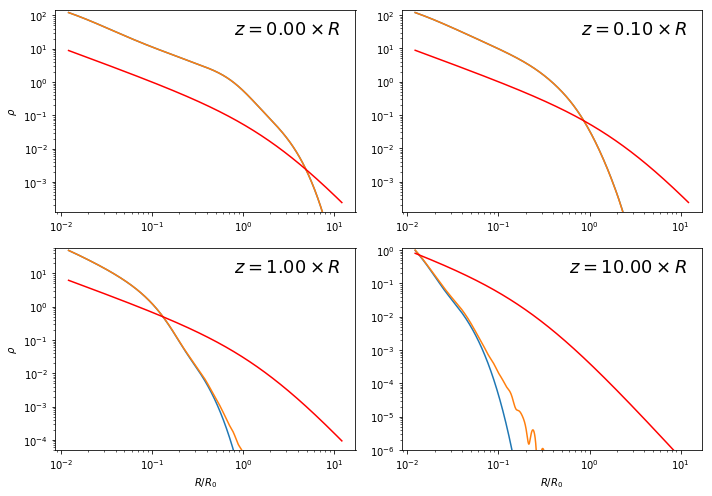

In [8]:
figsize(10,7)
Xs= [0.,1./10.,1.,10.]
xs= 10.**numpy.linspace(numpy.log10(0.1/R0.to(u.kpc).value),
                        numpy.log10(100./R0.to(u.kpc).value),1001)
for ii,X in enumerate(Xs):
    subplot(2,2,ii+1)
    loglog(xs,mcmillan.bulge_gas_dens(xs,xs*X))
    loglog(xs,mcm17[0].dens(xs,xs*X,use_physical=False)+mcm17[2].dens(xs,xs*X,use_physical=False))
    loglog(xs,mcm17[1].dens(xs,xs*X,use_physical=False), color='Red')
    ylim(10.**-6.*mcmillan.bulge_gas_dens(xs[0],xs[0]*X),
        1.2*mcmillan.bulge_gas_dens(xs[0],xs[0]*X))
    if ii > 1: xlabel(r'$R/R_0$')
    if ii%2 < 1: ylabel(r'$\rho$')
    bovy_plot.bovy_text(r'$z = {:.2f} \times R$'.format(X),size=18.,top_right=True)
tight_layout()

/home/astjmack/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in divide
  

/home/astjmack/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in divide
  



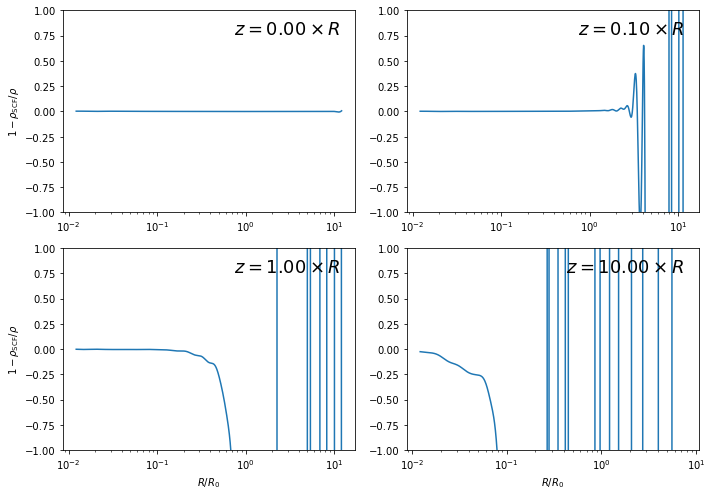

In [9]:
figsize(10,7)
Xs= [0.,1./10.,1.,10.]
xs= 10.**numpy.linspace(numpy.log10(0.1/R0.to(u.kpc).value),
                        numpy.log10(100./R0.to(u.kpc).value),1001)
for ii,X in enumerate(Xs):
    subplot(2,2,ii+1)
    plot_func= semilogx
    plot_func(xs,1.-(mcm17[0].dens(xs,xs*X,use_physical=False)+mcm17[2].dens(xs,xs*X,use_physical=False))/mcmillan.bulge_gas_dens(xs,xs*X))
    if ii > 1: xlabel(r'$R/R_0$')
    if ii%2 < 1: ylabel(r'$1-\rho_{\mathrm{SCF}}/\rho$')
    bovy_plot.bovy_text(r'$z = {:.2f} \times R$'.format(X),size=18.,top_right=True)
    ylim(-1.,1.)
tight_layout()

Just the disks (red is now bulge + halo):

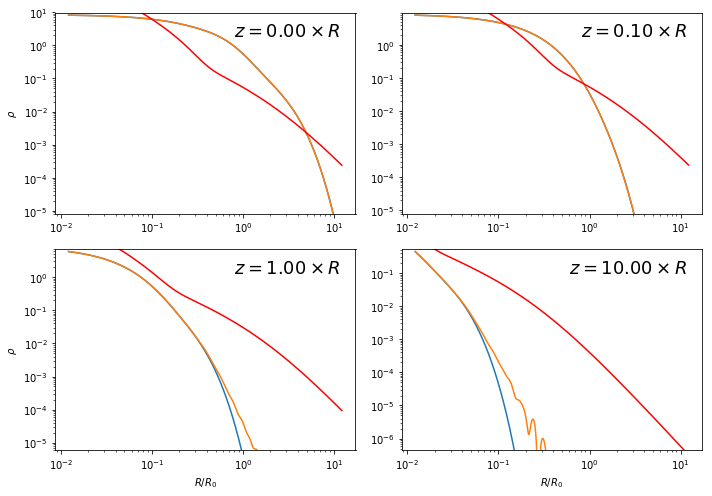

In [10]:
figsize(10,7)
Xs= [0.,1./10.,1.,10.]
xs= 10.**numpy.linspace(numpy.log10(0.1/R0.to(u.kpc).value),
                        numpy.log10(100./R0.to(u.kpc).value),1001)
for ii,X in enumerate(Xs):
    subplot(2,2,ii+1)
    loglog(xs,mcmillan.gas_stellar_dens(xs,xs*X))
    loglog(xs,mcm17[0].dens(xs,xs*X,use_physical=False))
    loglog(xs,mcm17[1].dens(xs,xs*X,use_physical=False)+mcm17[2].dens(xs,xs*X,use_physical=False), color='Red')
    ylim(10.**-6.*mcmillan.gas_stellar_dens(xs[0],xs[0]*X),
        1.2*mcmillan.gas_stellar_dens(xs[0],xs[0]*X))
    if ii > 1: xlabel(r'$R/R_0$')
    if ii%2 < 1: ylabel(r'$\rho$')
    bovy_plot.bovy_text(r'$z = {:.2f} \times R$'.format(X),size=18.,top_right=True)
tight_layout()

/home/astjmack/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in divide
  

/home/astjmack/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in divide
  

/home/astjmack/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:1193: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)



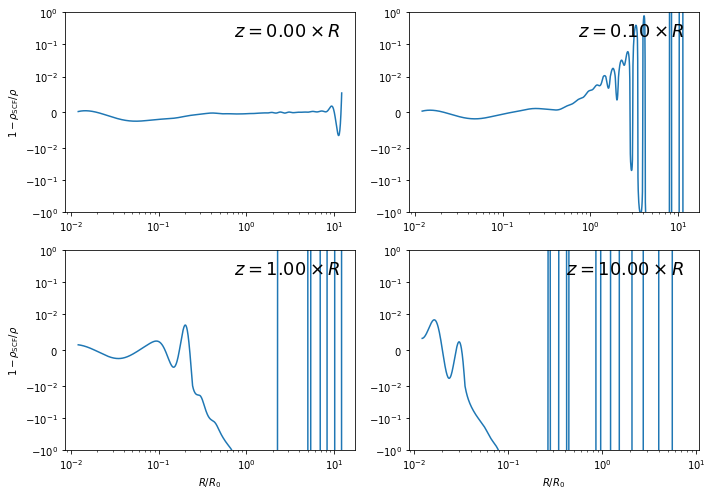

In [11]:
figsize(10,7)
Xs= [0.,1./10.,1.,10.]
xs= 10.**numpy.linspace(numpy.log10(0.1/R0.to(u.kpc).value),
                        numpy.log10(100./R0.to(u.kpc).value),1001)
for ii,X in enumerate(Xs):
    subplot(2,2,ii+1)
    plot_func= semilogx
    plot_func(xs,1.-(mcm17[0].dens(xs,xs*X,use_physical=False))/mcmillan.gas_stellar_dens(xs,xs*X))
    if ii > 1: xlabel(r'$R/R_0$')
    if ii%2 < 1: ylabel(r'$1-\rho_{\mathrm{SCF}}/\rho$')
    bovy_plot.bovy_text(r'$z = {:.2f} \times R$'.format(X),size=18.,top_right=True)
    ylim(-1.,1.)
    yscale('symlog',linthreshy=1e-2)
tight_layout()

Just the bulge (red is now disk+halo):

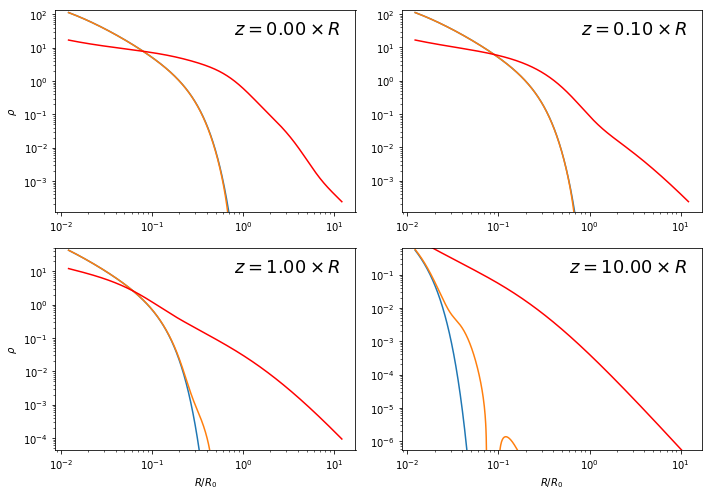

In [12]:
figsize(10,7)
Xs= [0.,1./10.,1.,10.]
xs= 10.**numpy.linspace(numpy.log10(0.1/R0.to(u.kpc).value),
                        numpy.log10(100./R0.to(u.kpc).value),1001)
for ii,X in enumerate(Xs):
    subplot(2,2,ii+1)
    loglog(xs,mcmillan.bulge_dens(xs,xs*X))
    loglog(xs,mcm17[2].dens(xs,xs*X,use_physical=False))
    loglog(xs,mcm17[1].dens(xs,xs*X,use_physical=False)+mcm17[0].dens(xs,xs*X,use_physical=False), color='Red')
    ylim(10.**-6.*mcmillan.bulge_dens(xs[0],xs[0]*X),
        1.2*mcmillan.bulge_dens(xs[0],xs[0]*X))
    if ii > 1: xlabel(r'$R/R_0$')
    if ii%2 < 1: ylabel(r'$\rho$')
    bovy_plot.bovy_text(r'$z = {:.2f} \times R$'.format(X),size=18.,top_right=True)
tight_layout()

/home/astjmack/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in divide
  

/home/astjmack/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in divide
  



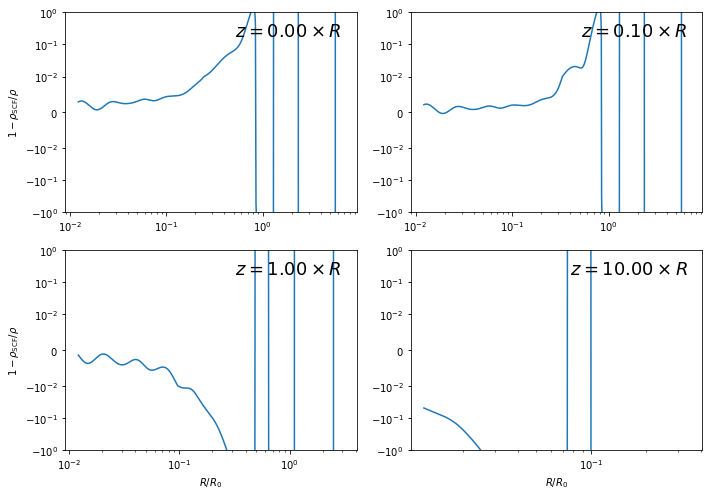

In [13]:
figsize(10,7)
Xs= [0.,1./10.,1.,10.]
xs= 10.**numpy.linspace(numpy.log10(0.1/R0.to(u.kpc).value),
                        numpy.log10(100./R0.to(u.kpc).value),1001)
for ii,X in enumerate(Xs):
    subplot(2,2,ii+1)
    plot_func= semilogx
    plot_func(xs,1.-(mcm17[2].dens(xs,xs*X,use_physical=False))/mcmillan.bulge_dens(xs,xs*X))
    if ii > 1: xlabel(r'$R/R_0$')
    if ii%2 < 1: ylabel(r'$1-\rho_{\mathrm{SCF}}/\rho$')
    bovy_plot.bovy_text(r'$z = {:.2f} \times R$'.format(X),size=18.,top_right=True)
    ylim(-1.,1.)
    yscale('symlog',linthreshy=1e-2)
tight_layout()

# Testing the method in this potential

We can perform the tests as done for the `galpy` `MWPotential2014` in this new potential using the code as before, but swapping in this potential. As in the other notebook in this repo, you may want to adjust the `nE` and `nL` parameters to shorten the runtime for computing the integrations on the grid! This code numerically finds the second derivatives of the potential, to calculate the delta parameter for each point in the grid, and so can be quite lengthy to run!

In [14]:
logLmin, logLmax= -0.3, 0.3
logEmin, logEmax= -2., -0.5
nL, nE= 101,101

if os.path.isfile('../sav/params_estimateddelta_staeckel_mcmillan.dat'):
    #load saved parameter file if it is present, if not - do calculations!
    with open('../sav/params_estimateddelta_staeckel_mcmillan.dat', 'r') as f:
        obj = pickle.load(f)
    int_param ,ana_param, deltas = obj
else:
    initgrid = orbit_helper.orbits_on_grid(logE_range=[logEmin,logEmax], logL_range=[logLmin,logLmax], nE = nE, nL =nL)
    initlist = initgrid.reshape(nE*nL,6)
    ana_param = np.empty([len(initlist),4])
    int_param = np.empty([len(initlist),4])
    delta = np.empty(len(initlist))
    for i in tqdm_notebook(range(len(initlist))):
        orb = Orbit(vxvv=initlist[i])
        ana_param[i], int_param[i], delta[i]  = orbit_helper.integrate_and_compare(orb, pot=McMillan2017, deltapot=McMillan2017, return_delta=True)
    obj = [int_param ,ana_param, delta]
    with open('../sav/params_estimateddelta_staeckel_mcmillan.dat', 'w') as f:
        pickle.dump(obj, f)



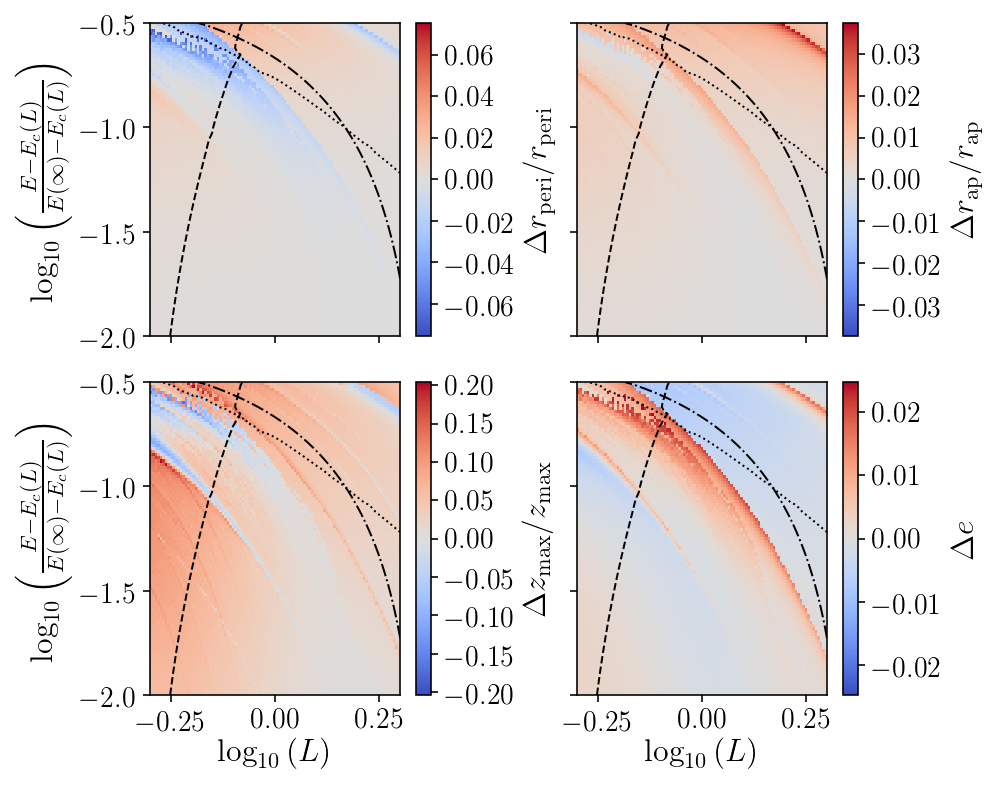

In [17]:

legrid = np.mgrid[logEmin:logEmax:101j,logLmin:logLmax:101j]
extent = [logLmin, logLmax, logEmin, logEmax]
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)
fig.set_size_inches(textwidth, 0.8*textwidth)
labels = [r'$\Delta r_{\mathrm{peri}}/r_{\mathrm{peri}}$',r'$\Delta r_{\mathrm{ap}}/r_{\mathrm{ap}}$',r'$\Delta z_{\mathrm{max}}/z_{\mathrm{max}}$',r'$\Delta e$']
inds = [2,3,1,0]
for i in range(len(labels)):
    index = inds[i]
    if index < 3:
        de = (int_param[:,index].reshape(nE,nL)-ana_param[:,index].reshape(nE,nL))/int_param[:,index].reshape(nE,nL)
        
    else:
        de = int_param[:,index].reshape(nE,nL)-ana_param[:,index].reshape(nE,nL)
        
    lim = np.nanmax(np.fabs(de))
    s = ax.ravel()[i].imshow(de[::-1], cmap=plt.cm.coolwarm, extent=extent, aspect='auto', vmin=-lim, vmax=lim)
    rpCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],int_param[:,2].reshape(nE,nL)[::-1], levels = [4./8.], colors='Black', linestyles='dashed', label=r'$R_{\mathrm{peri}} = 4\ \mathrm{kpc}$')
    raCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],int_param[:,3].reshape(nE,nL)[::-1], levels = [20./8.], colors='Black', linestyles='dashdot', label=r'$R_{\mathrm{apo}} = 20\ \mathrm{kpc}$')
    zmCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],int_param[:,1].reshape(nE,nL)[::-1], levels = [4./8.], colors='Black', linestyles='dotted', label=r'$Z_{\mathrm{max}} = 4\ \mathrm{kpc}$')
    plt.colorbar(s, label=labels[i], ax=ax.ravel()[i])

ax[1,0].set_xlabel(r'$\log_{10}{(L)}$')
ax[1,1].set_xlabel(r'$\log_{10}{(L)}$')
ax[0,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[1,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
fig.tight_layout()
plt.savefig('../plots/orbit_param_comparison_mcmillan.pdf', format='pdf')
plt.savefig('../plots/orbit_param_comparison_mcmillan.png', format='png', dpi=400)


The increased complexity of this potential is obvious in the residuals here, which have more substructure than in `MWPotential2014`. The estimation of $z_\mathrm{max}$ is particularly not as good here.

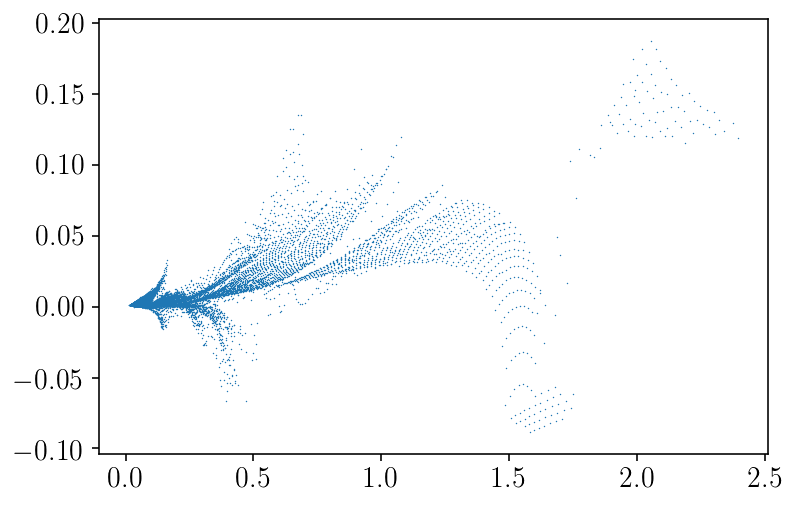

In [19]:
plt.scatter(int_param[:,1], int_param[:,1]-ana_param[:,1], s=0.5, lw=0.)

we can also compare the parameters at equal energy and angular momenta in the two potentials, assuming the same Delta parameters:

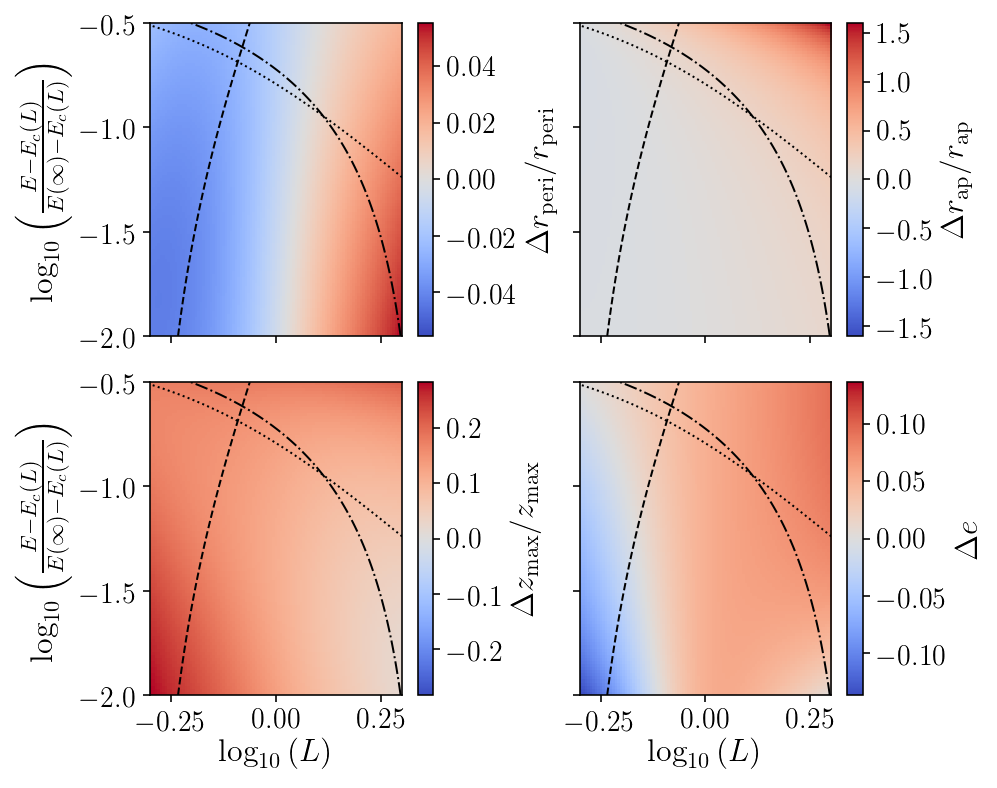

In [24]:
logLmin, logLmax= -0.3, 0.3
logEmin, logEmax= -2., -0.5
nL, nE= 101,101

initgrid = orbit_helper.orbits_on_grid(logE_range=[logEmin,logEmax], logL_range=[logLmin,logLmax], nE = nE, nL =nL)

aAS_mm = actionAngle.actionAngleStaeckel(pot=mcm17, delta=0.4)
aAS_mw = actionAngle.actionAngleStaeckel(pot=potential.MWPotential2014, delta=0.4)

param_mm = aAS_mm.EccZmaxRperiRap(initgrid[:,:,0].ravel(), 
                    initgrid[:,:,1].ravel(), 
                    initgrid[:,:,2].ravel(),
                    initgrid[:,:,3].ravel(),
                    initgrid[:,:,4].ravel(),
                    initgrid[:,:,5].ravel())

param_mw = aAS_mw.EccZmaxRperiRap(initgrid[:,:,0].ravel(), 
                    initgrid[:,:,1].ravel(), 
                    initgrid[:,:,2].ravel(),
                    initgrid[:,:,3].ravel(),
                    initgrid[:,:,4].ravel(),
                    initgrid[:,:,5].ravel())


legrid = np.mgrid[logEmin:logEmax:101j,logLmin:logLmax:101j]

extent = [logLmin, logLmax, logEmin, logEmax]
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)
fig.set_size_inches(textwidth, 0.8*textwidth)
labels = [r'$\Delta r_{\mathrm{peri}}/r_{\mathrm{peri}}$',r'$\Delta r_{\mathrm{ap}}/r_{\mathrm{ap}}$',r'$\Delta z_{\mathrm{max}}/z_{\mathrm{max}}$',r'$\Delta e$']
inds = [2,3,1,0]
for i in range(len(labels)):
    index = inds[i]
    if index < 3:
        de = (param_mw[index].reshape(nE,nL)-param_mm[index].reshape(nE,nL))/param_mw[index].reshape(nE,nL)
        
    else:
        de = param_mw[index].reshape(nE,nL)-param_mm[index].reshape(nE,nL)
        
    lim = np.nanmax(np.fabs(de))
    s = ax.ravel()[i].imshow(de[::-1], cmap=plt.cm.coolwarm, extent=extent, aspect='auto', vmin=-lim, vmax=lim)
    rpCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],param_mw[2].reshape(nE,nL)[::-1], levels = [4./8.], colors='Black', linestyles='dashed', label=r'$R_{\mathrm{peri}} = 4\ \mathrm{kpc}$')
    raCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],param_mw[3].reshape(nE,nL)[::-1], levels = [20./8.], colors='Black', linestyles='dashdot', label=r'$R_{\mathrm{apo}} = 20\ \mathrm{kpc}$')
    zmCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],param_mw[1].reshape(nE,nL)[::-1], levels = [4./8.], colors='Black', linestyles='dotted', label=r'$Z_{\mathrm{max}} = 4\ \mathrm{kpc}$')
    plt.colorbar(s, label=labels[i], ax=ax.ravel()[i])

ax[1,0].set_xlabel(r'$\log_{10}{(L)}$')
ax[1,1].set_xlabel(r'$\log_{10}{(L)}$')
ax[0,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[1,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
fig.tight_layout()

It is clear that the parameters which are estimated in both potentials can be quite different to one another. Particularly, $z_\mathrm{max}$ has a significant and systematic offset of between 10 and 20%, such that $z_\mathrm{max}$ is underestimated in McMillan2017 relative to `MWPotential2014`. At the maximum energy and angular momentum, $r_{\mathrm{ap}}$ is roughly 150% different! In general, in the disk region, the difference in eccentricity is around the 5% level.